# Case Study: Neuro

Here is the case study for pancreatic endocrinogenesis dataset. 8 cell types were included.
For the mouse hippocampal dentate gyrus neurogenesis data, we followed the gene and cell filtering methods by La Manno et al.(link), and selected 18,140 cells with 2,159 genes. 

The notebook is also available at github(xxxx.ipynb).

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
# srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
#srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
from celldancer.velocity_estimation import velocity
from celldancer.compute_cell_velocity import compute
from celldancer.pseudo_time import pseudo_time
from celldancer.embedding_kinetic_para import embedding

## Velocity Estimation for Sample Genes

To load the data to estimate the velocity, the dataset containing spliced unspliced reads of each genes with the corresponding cell could be downloaded from http:xxxxx/cell_type_u_s.csv. It can be loaded by pd.read_csv('your_path/cell_type_u_s.csv'). 

You can transfer other format (*.loom) to the accepted .csv format by using utilities.adata_to_csv('file.loom',xxxxx(other parameters)).


In cell_type_u_s, each row represents each individual cell of a gene. The rows will be the length of cells * the amount of genes.

In [95]:
%autoreload 2

cell_type_u_s_path="/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv"
#cell_type_u_s_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/DentateGyrus.csv'
#cell_type_u_s_path='/Users/chen.weiqing/code/celldancer/DentateGyrus.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Rgs20,0.069478,0.021971,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,Rgs20,0.085834,0.016256,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,Rgs20,0.068644,0.047774,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,Rgs20,0.045387,0.018101,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,Rgs20,0.040457,0.012846,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...
39164255,Gpm6b,0.876650,1.276089,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
39164256,Gpm6b,2.024897,5.152006,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
39164257,Gpm6b,1.848051,1.491445,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
39164258,Gpm6b,0.696361,1.189091,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


You can run ```velocity_estimation.velocity(cell_type_u_s)``` to estimate the velocity. 
Here, we will only estimate the genes in gene_list by using it as the input of velocity(). 

In [124]:
%autoreload 2

max_epoches=200#200
check_val_every_n_epoch=10#10
patience=3
permutation_ratio=0.1
speed_up=True
norm_u_s=False
norm_cell_distribution=False
n_jobs=8
save_path=None

# no deleted
gene_list=['Klf7', 'Scn2a1', 'Tmem163', 'Gnao1', 'Grm7', 'Dctn3', 'Plppr4', 'Shisa9', 'Pak3', 'Camk4', 'Evl', 'Slc24a2', 'Atp1a3', 'Dcx', 'Foxk2', 'Slc24a3', 'Gabrg3', 'Slc4a4', 'Prkag2', 'Nrxn1', 'Gpm6b', 'Fads2', 'Anks1b', 'Sfxn5', 'Ppfia2', 'Stxbp6', 'Ank2', 'Rgma', 'Gria1', 'Ablim1', 'Psd3', 'Ntrk2', 'Ncald', 'Abca1', 'Slc1a3', 'Hepacam', 'Spock3', 'Unc80', 'Nsf', 'Rims1', 'Astn1', 'Cdh9', 'Cdh13', 'Map1b', 'Camk2a', 'Dlgap1', 'Syt11', 'Sptbn1', 'Tbc1d16', 'Cadm1', 'Nav1', 'Sphkap', 'Prkcg', 'Ptpro', 'Adam23', 'Raver2', 'Pcsk2', 'Sez6l', 'Diaph3', 'Adgrb3', 'Kcnip1', 'Ppp3ca']

# kept 20
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Stxbp6', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Camk2a', 'Evl','Tbc1d16', 'Cadm1', 'Kcnip1', 'Ptpro', 'Sez6l', 'Diaph3',]

# 30
gene_list=['Psd3', 'Dcx', 'Syt11', 'Diaph3', 'Slc1a3', 'Gria1', 'Dctn3', 'Map1b', 'Camk2a', 'Gpm6b', 'Sez6l', 'Evl', 'Astn1', 'Ank2', 'Klf7', 'Tbc1d16', 'Atp1a3', 'Stxbp6', 'Scn2a1', 'Lhx9', 'Slc4a4', 'Ppfia2', 'Kcnip1', 'Ptpro', 'Ntrk2', 'Gnao1', 'Cadm1', 'Mef2c', 'Sptbn1', 'Ncald']
# Velocity Estimation
loss_df, cellDancer_df=velocity(cell_type_u_s,\
                                         gene_list=gene_list,\
                                         max_epoches=max_epoches,\
                                         check_val_every_n_epoch=check_val_every_n_epoch,\
                                         patience=patience,\
                                         permutation_ratio=permutation_ratio,\
                                         speed_up=speed_up,\
                                         norm_u_s=norm_u_s,\
                                         norm_cell_distribution=norm_cell_distribution,\
                                         n_jobs=n_jobs,\
                                         save_path=save_path)
cellDancer_df

Using /Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/CaseStudyNotebook/cell_dancer_velocity_2022-05-30 18-33-48 as the output path.
Arranging genes for parallel job.
30  genes were arranged to  1  portion.


Velocity Estimation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.01s/it]


,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Klf7,0.408467,1.294797,0.444935,1.475828,0.454905,0.935128,0.015373,0.077489,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,1,Klf7,0.379136,1.256870,0.411796,1.424216,0.419835,0.935061,0.015772,0.077489,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,2,Klf7,0.893599,3.395004,0.969404,3.832591,1.033540,0.986942,0.001990,0.077489,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,3,Klf7,0.640505,2.739187,0.669036,3.047821,0.684626,0.979797,0.003759,0.077489,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,4,Klf7,0.662303,2.433943,0.712970,2.749427,0.745024,0.971894,0.005226,0.077489,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544195,18135,Kcnip1,0.018745,0.005679,0.243844,0.008779,0.463909,0.731405,1.322285,0.079982,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
544196,18136,Kcnip1,0.148039,0.093618,0.380534,0.085685,0.572677,0.727422,1.319759,0.079982,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
544197,18137,Kcnip1,0.080708,0.032079,0.312729,0.040230,0.522807,0.728119,1.323665,0.079982,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
544198,18138,Kcnip1,0.078976,0.033418,0.310343,0.040067,0.520257,0.728360,1.323348,0.079982,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


## Sample Genes' Velocity Plot

The velocity of one gene colud be viewed by ```cdplt.gene.scatter_gene()```. The y-axis represent the unspliced read.

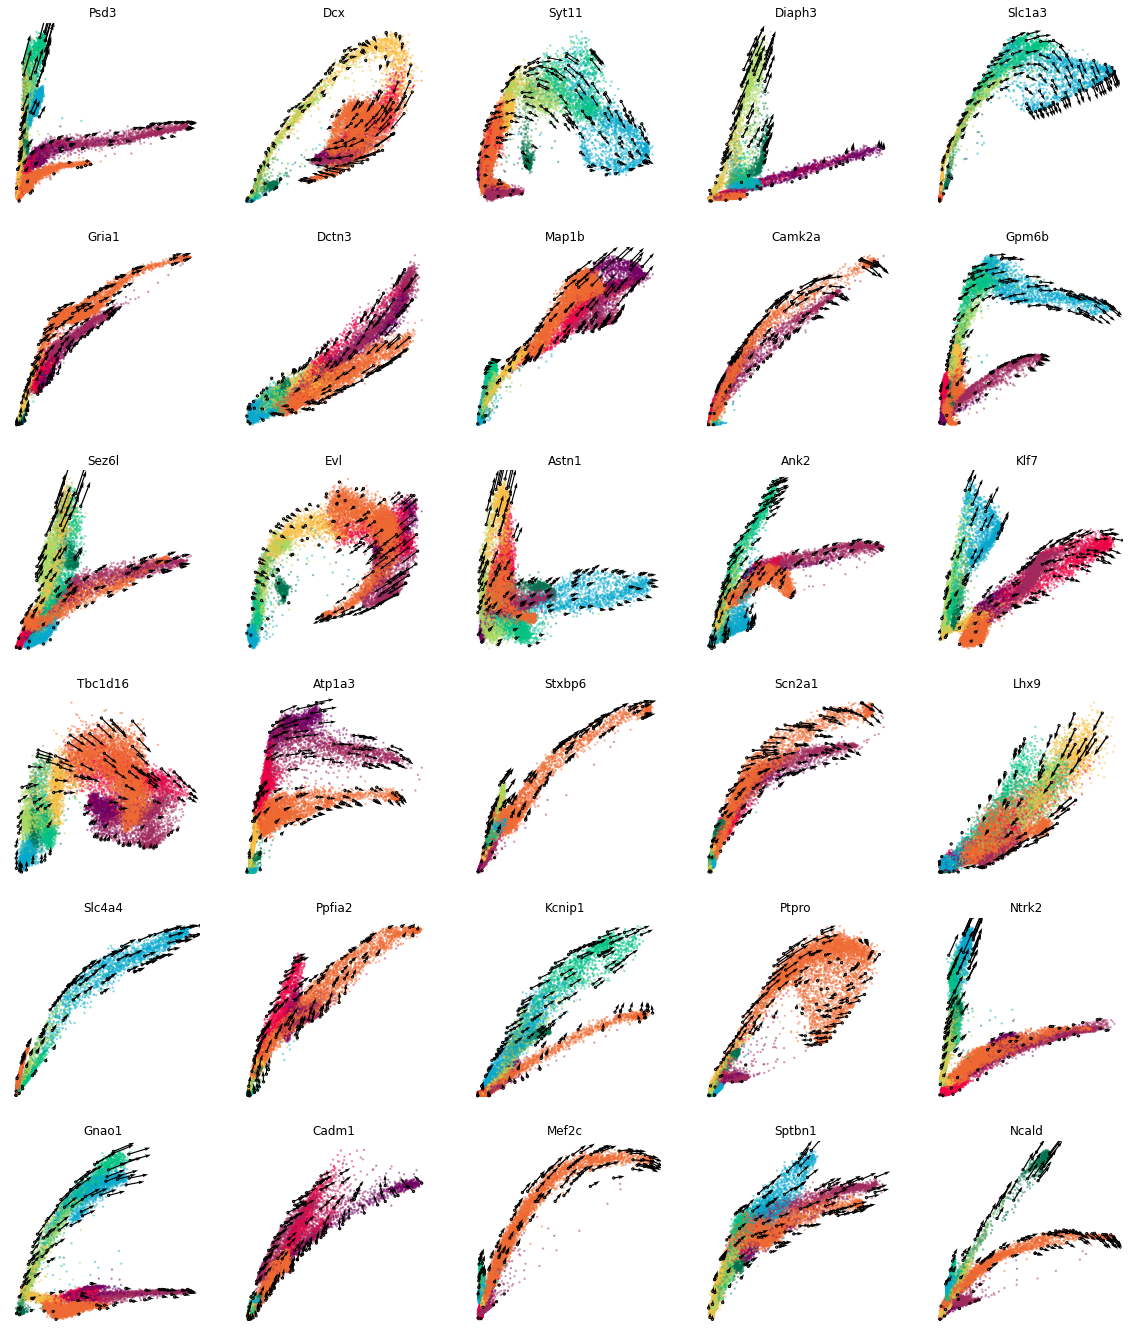

In [125]:
%autoreload 2

# gene_list=list(cellDancer_df[cellDancer_df.gene_name.isin(gene_list)]['gene_name'].drop_duplicates())

ncols=5

height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')
plt.savefig('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/storyboard/30_sample_genes_8njob.pdf')
# plt.savefig('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/storyboard/Evl_genes.pdf')


plt.show()

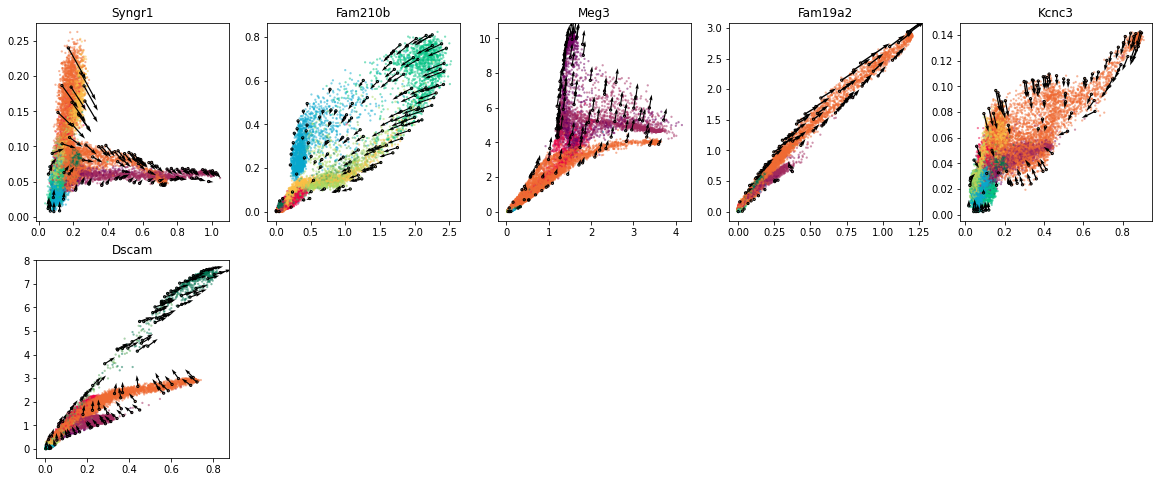

In [163]:
%autoreload 2

# gene_list=list(cellDancer_df[cellDancer_df.gene_name.isin(gene_list)]['gene_name'].drop_duplicates())

ncols=5
gene_list_branch=['Syngr1','Fam210b','Meg3','Fam19a2','Kcnc3','Dscam']
height=math.ceil(len(gene_list_branch)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list_branch)):
    ax = fig.add_subplot(math.ceil(len(gene_list_branch)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list_branch[i])
    
    ax.set_title(gene_list_branch[i])
    # ax.axis('off')
# plt.savefig('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/storyboard/30_sample_genes_8njob.pdf')
# plt.savefig('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/storyboard/Evl_genes.pdf')


plt.show()

## Load velocity estimation result of 2159 genes

There is data already predicted available at xxx. You can also predict your own. 

In [127]:
#detail_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000genes_with_bin_and_smooth/combined_detail/combined_detail.csv'
cellDancer_df_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/celldancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_file)
loss_df_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/loss.csv'
loss_df=pd.read_csv(loss_df_file)

array([[<AxesSubplot:title={'center':'loss'}>]], dtype=object)

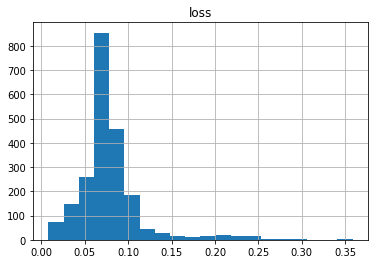

In [131]:
gene_loss=cellDancer_df[['gene_name','loss']].drop_duplicates()


In [132]:
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Stxbp6', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Camk2a', 'Evl','Tbc1d16', 'Cadm1', 'Kcnip1', 'Ptpro', 'Sez6l', 'Diaph3',]

<AxesSubplot:ylabel='Frequency'>

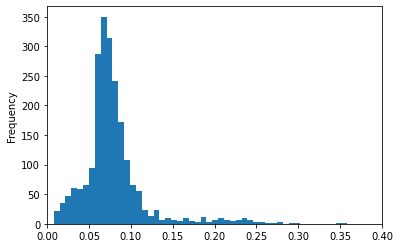

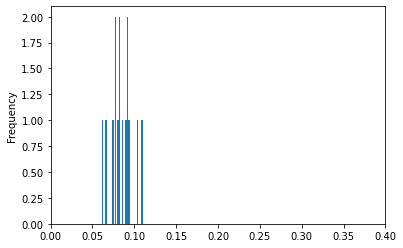

In [146]:
gene_loss_20genes=gene_loss[gene_loss.gene_name.isin(gene_list)]
plt.figure()
gene_loss['loss'].plot.hist(xlim=(0,0.4),bins=50)
plt.figure()
gene_loss_20genes['loss'].plot.hist(xlim=(0,0.4),bins=40)

<AxesSubplot:title={'center':'hist loss'}, ylabel='Density'>

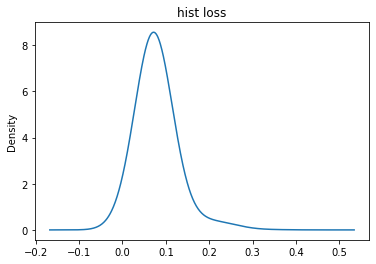

In [152]:
fig, ax = plt.subplots()
gene_loss.loss.plot.kde(ax=ax, legend=False, title='hist loss',bw_method=1)


In [145]:
gene_loss_20genes.sort_values('loss')

,gene_name,loss
30674740,Syt11,0.060929
32996660,Cadm1,0.064899
4408020,Dctn3,0.066869
6385280,Dcx,0.073448
17940460,Evl,0.074870
671180,Klf7,0.077477
2739140,Gnao1,0.078081
38783320,Kcnip1,0.079982
19409800,Ncald,0.081272
37187000,Sez6l,0.082143


cellDancer_df## Compute Cell Velocity

In [155]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Stom,0.000000,0.006305,9.385150e-07,0.006294,0.000002,0.951817,0.003524,0.068943,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429,0,NaN,NaN
1,1,Stom,0.000000,0.006305,9.385150e-07,0.006294,0.000002,0.951817,0.003524,0.068943,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895,1,NaN,NaN
2,2,Stom,0.000000,0.008353,9.295276e-07,0.008339,0.000002,0.951943,0.003514,0.068943,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419,2,NaN,NaN
3,3,Stom,0.000000,0.000000,9.668082e-07,0.000000,0.000002,0.951425,0.003555,0.068943,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485,3,NaN,NaN
4,4,Stom,0.000000,0.000000,9.668082e-07,0.000000,0.000002,0.951425,0.003555,0.068943,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39109835,18135,Prmt8,0.131071,0.262922,1.410238e-01,0.266331,0.095084,0.573575,0.260010,0.109623,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668,18135,NaN,NaN
39109836,18136,Prmt8,0.198949,0.531809,2.013258e-01,0.517340,0.117767,0.568054,0.266923,0.109623,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788,18136,NaN,NaN
39109837,18137,Prmt8,0.173362,0.212177,1.804222e-01,0.234265,0.112805,0.569238,0.256904,0.109623,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364,18137,NaN,NaN
39109838,18138,Prmt8,0.216978,0.338159,2.186953e-01,0.355581,0.126118,0.565421,0.259761,0.109623,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549,18138,NaN,NaN


(genes, cells): (2156, 18140)


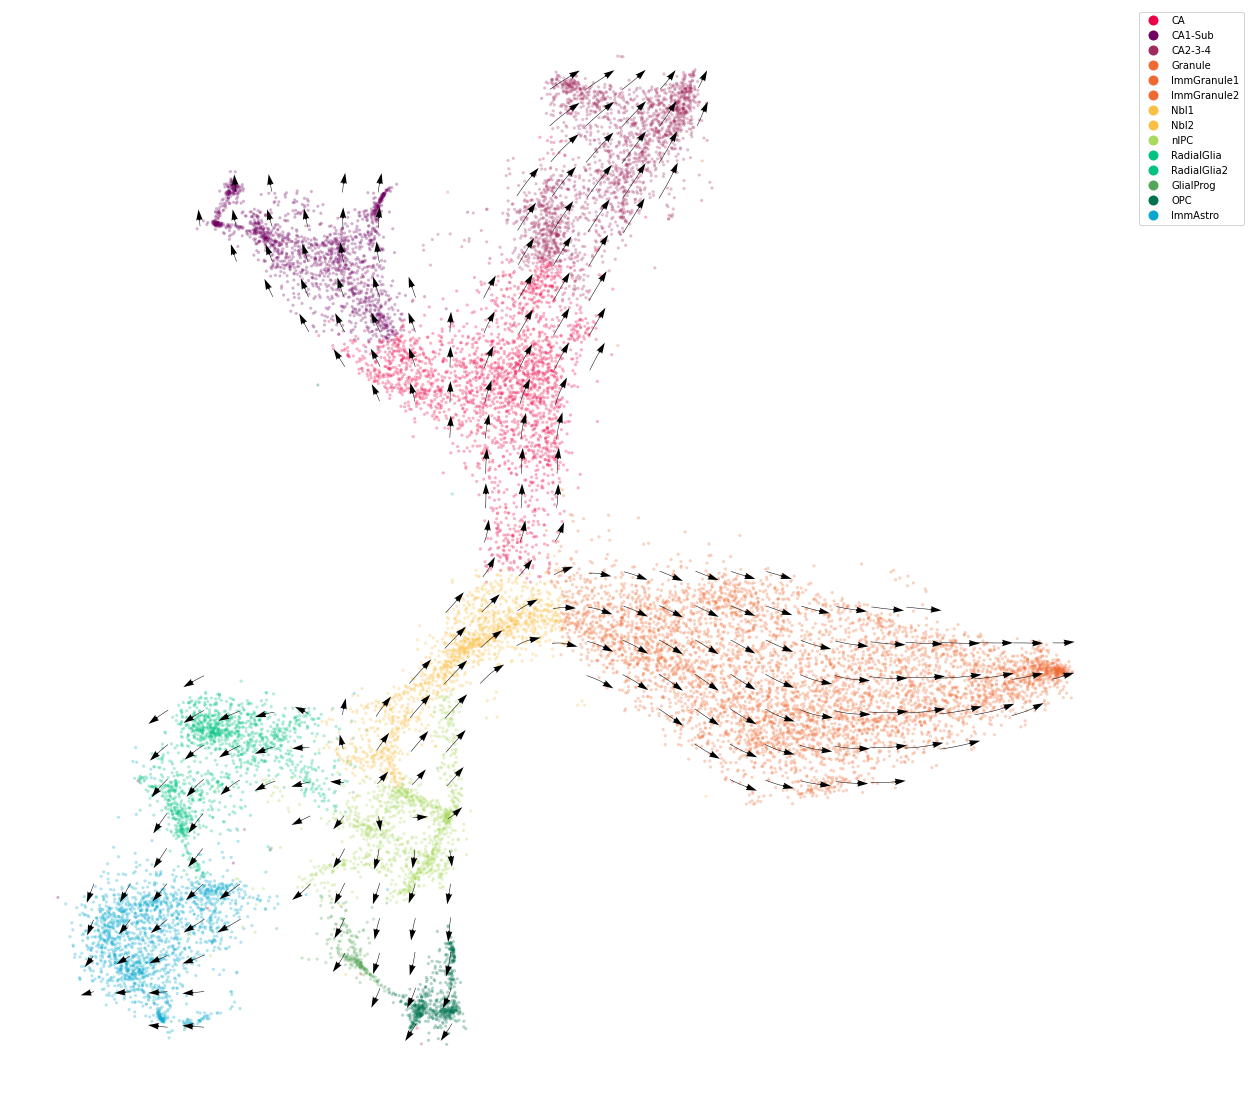

In [154]:
%autoreload 2

# Set Parameters
projection_neighbor_choice='embedding'
expression_scale=None
projection_neighbor_size=200
speed_up=(60,60)

# Compute cell velocity
cellDancer_df=compute(cellDancer_df=cellDancer_df,
              projection_neighbor_choice=projection_neighbor_choice,
              expression_scale=expression_scale,
              projection_neighbor_size=projection_neighbor_size,
              speed_up=speed_up)

# Plot cell velocity
# Set Parameters
min_mass=2
arrow_grid=(30,30)
alpha_inside=0.3


fig, ax = plt.subplots(figsize=(20,20))
im = cdplt.cell.scatter_cell(ax,cellDancer_df, colors=colormap.colormap_neuro, alpha=alpha_inside, s=10,
             velocity=True, legend='on',min_mass=min_mass,arrow_grid=arrow_grid)
ax.axis('off')
plt.show()

## Estimate Pseudotime

Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8880/8880 [03:30<00:00, 42.24it/s]


use path_similarity:  0.25
There are 5 clusters.
[0 1 2 3 4]


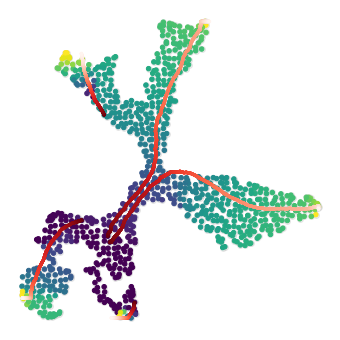




Cluster  0
Total cells in the cluster:  450
MAX allowed zero time cells:  22
MAX allowed terminal cells:  22
Only  1  terminal cells left.
[603]
72  zero cells left.
Sample trajs for zero-time cells in cluster  0   ...
Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Cluster  0
Total cells in the cluster:  72
MAX allowed zero time cells:  22
MAX allowed terminal cells:  22
Only  7  zero cells left. 
[80, 193, 204, 258, 403, 598, 682]
Only  3  terminal cells left.
[666, 748, 870]
number of paths:  2 2

Display reference paths for cluster 0


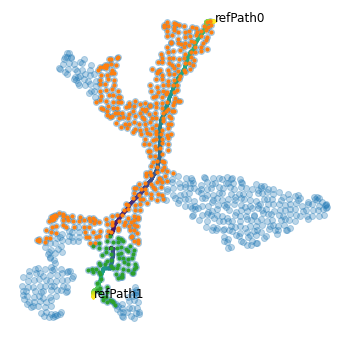


intercluster cell time adjustment
number of cells:  450
Cutoff is  0.05338801800641271
Number of nodes:  2
clusterIDs:  [0, 1]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (90, 102)
pair_cellIDs:  (425, 80)
pair_cellIDs:  (501, 16)
pair_cellIDs:  (343, 204)
pair_cellIDs:  (457, 658)
pair_cellIDs:  (151, 671)
pair_cellIDs:  (391, 709)
pair_cellIDs:  (237, 22)
pair_cellIDs:  (564, 682)
pair_cellIDs:  (643, 818)
pair_cellIDs:  (850, 451)
pair_cellIDs:  (839, 836)
pair_cellIDs:  (842, 802)
pair_cellIDs:  (414, 403)

Peak mode:  most_frequent_shift


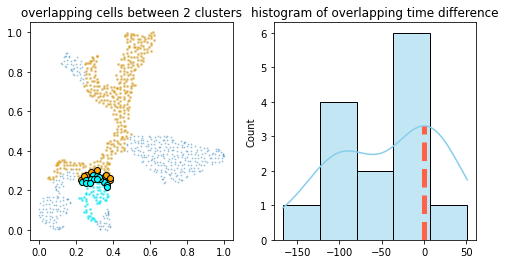

Time shift is:  1
The overlapping cells are: 
cell  425  from cluster  0  and  80  from cluster  1


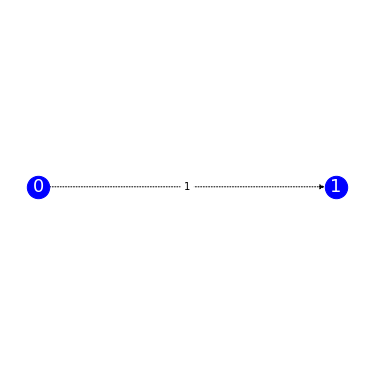

Connected components:  {0, 1}
All nodes adjustment:  {0: 0, 1: 1}



Cluster  1
Total cells in the cluster:  278
MAX allowed zero time cells:  13
MAX allowed terminal cells:  13
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[599]
number of paths:  1 1

Display reference paths for cluster 1


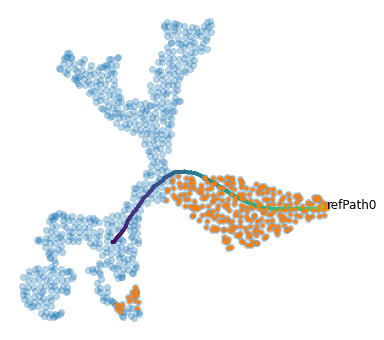




Cluster  2
Total cells in the cluster:  106
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[742]
number of paths:  1 1

Display reference paths for cluster 2


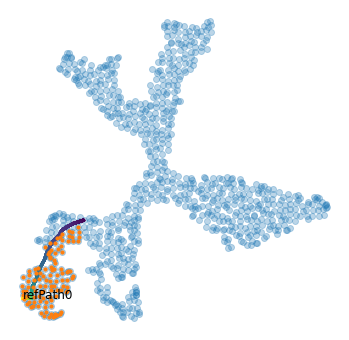




Cluster  3
Total cells in the cluster:  43
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  2  terminal cells left.
[230, 649]
number of paths:  1 1

Display reference paths for cluster 3


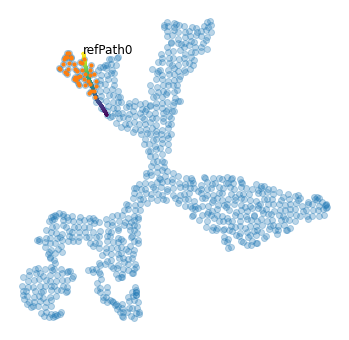




Cluster  4
Total cells in the cluster:  11
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[849]
number of paths:  1 1

Display reference paths for cluster 4


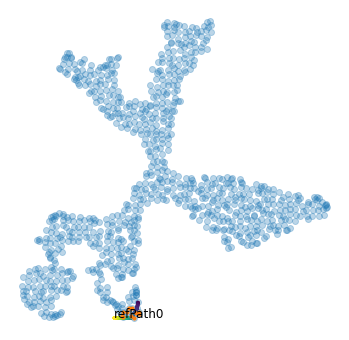




All intra cluster cell time has been resolved.




intercluster cell time adjustment
number of cells:  888
Cutoff is  0.058423757617624104
Number of nodes:  5
clusterIDs:  [0, 1, 2, 3, 4]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (666, 419)
pair_cellIDs:  (857, 540)
pair_cellIDs:  (140, 336)
pair_cellIDs:  (811, 197)
pair_cellIDs:  (716, 72)
pair_cellIDs:  (689, 213)
pair_cellIDs:  (119, 803)
pair_cellIDs:  (60, 668)
pair_cellIDs:  (417, 159)
pair_cellIDs:  (242, 799)
pair_cellIDs:  (310, 329)
pair_cellIDs:  (157, 199)
pair_cellIDs:  (535, 688)
pair_cellIDs:  (130, 187)
pair_cellIDs:  (870, 487)
pair_cellIDs:  (319, 789)

Peak mode:  most_frequent_shift


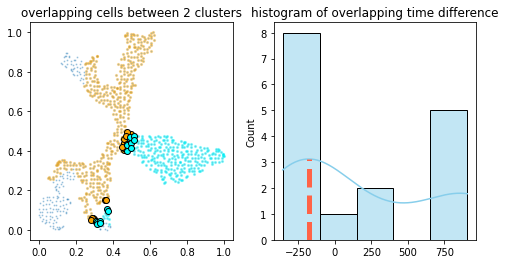

Time shift is:  -180
The overlapping cells are: 
cell  811  from cluster  0  and  197  from cluster  1

Consolidating time between clusters  0  and  2 ...
pair_cellIDs:  (272, 267)
pair_cellIDs:  (662, 288)
pair_cellIDs:  (416, 99)
pair_cellIDs:  (753, 148)
pair_cellIDs:  (203, 569)
pair_cellIDs:  (254, 125)
pair_cellIDs:  (261, 807)
pair_cellIDs:  (868, 856)
pair_cellIDs:  (438, 266)
pair_cellIDs:  (683, 307)
pair_cellIDs:  (884, 132)
pair_cellIDs:  (260, 781)
pair_cellIDs:  (572, 248)
pair_cellIDs:  (118, 13)
pair_cellIDs:  (744, 280)
pair_cellIDs:  (648, 23)
pair_cellIDs:  (734, 325)
pair_cellIDs:  (557, 345)
pair_cellIDs:  (564, 131)

Peak mode:  most_frequent_shift


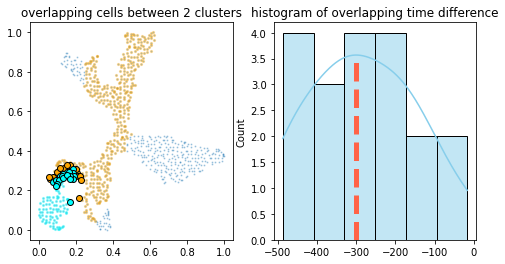

Time shift is:  -308
The overlapping cells are: 
cell  564  from cluster  0  and  131  from cluster  2

Consolidating time between clusters  0  and  3 ...
pair_cellIDs:  (235, 366)
pair_cellIDs:  (295, 139)
pair_cellIDs:  (362, 225)
pair_cellIDs:  (223, 77)
pair_cellIDs:  (160, 296)
pair_cellIDs:  (381, 38)
pair_cellIDs:  (127, 252)
pair_cellIDs:  (354, 196)
pair_cellIDs:  (341, 427)
pair_cellIDs:  (19, 285)
pair_cellIDs:  (384, 184)

Peak mode:  most_frequent_shift


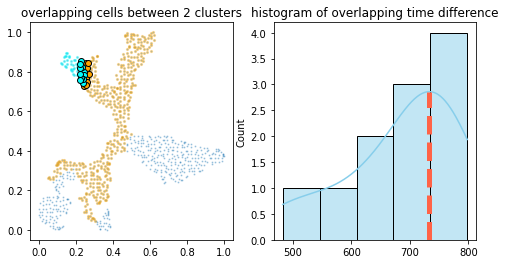

Time shift is:  730
The overlapping cells are: 
cell  341  from cluster  0  and  427  from cluster  3

Consolidating time between clusters  0  and  4 ...
pair_cellIDs:  (666, 657)
pair_cellIDs:  (119, 257)

Peak mode:  least_shift


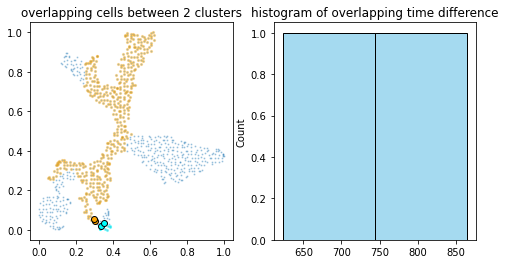

Time shift is:  623
The overlapping cells are: 
cell  666  from cluster  0  and  657  from cluster  4

Consolidating time between clusters  1  and  2 ...
No close cells between clusters	 (1, 2)

Consolidating time between clusters  1  and  3 ...
No close cells between clusters	 (1, 3)

Consolidating time between clusters  1  and  4 ...
pair_cellIDs:  (790, 657)
pair_cellIDs:  (189, 609)
pair_cellIDs:  (487, 463)
pair_cellIDs:  (329, 257)
pair_cellIDs:  (222, 718)
pair_cellIDs:  (668, 849)
pair_cellIDs:  (227, 611)
pair_cellIDs:  (803, 664)
pair_cellIDs:  (717, 732)

Peak mode:  most_frequent_shift


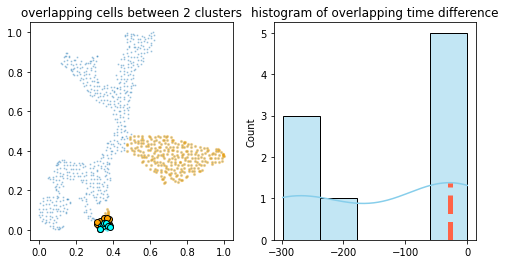

Time shift is:  0
The overlapping cells are: 
cell  329  from cluster  1  and  257  from cluster  4

Consolidating time between clusters  2  and  3 ...
No close cells between clusters	 (2, 3)

Consolidating time between clusters  2  and  4 ...
No close cells between clusters	 (2, 4)

Consolidating time between clusters  3  and  4 ...
No close cells between clusters	 (3, 4)


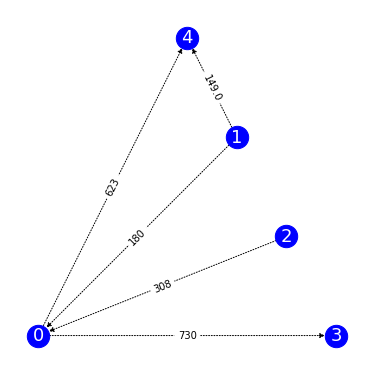

Connected components:  {0, 1, 2, 3, 4}
There are cycle(s), forcing a break.
All nodes adjustment:  {0: -20075, 1: -19452, 2: 0, 3: 0, 4: -19452}


All inter cluster cell time has been resolved.



There are 18140 cells.


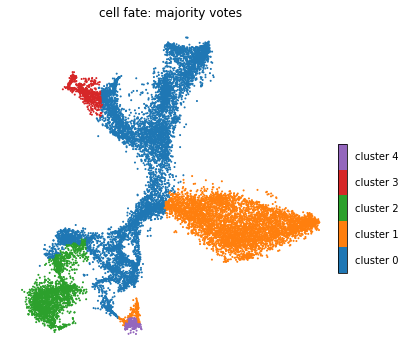

--- 362.36418294906616 seconds ---


In [156]:
%autoreload 2

dt = 0.001
t_total = {0.001: 10000}
n_repeats = 10

speed_up=(60,60)
grid = (30, 30)
load_cellDancer = pseudo_time(
    cellDancer_df=cellDancer_df, 
    grid=grid, 
    dt=dt, 
    t_total=t_total[dt], 
    n_repeats=n_repeats, 
    speed_up=speed_up,
    n_paths = 5,
    psrng_seeds_diffusion=[i for i in range(n_repeats)],
    activate_umap_paths_divider=False,
    n_jobs=12)

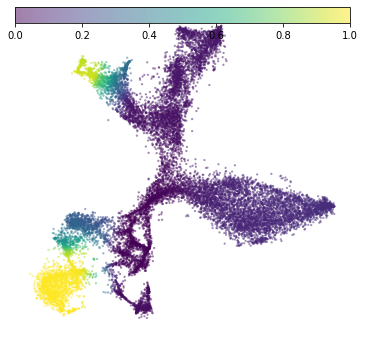

In [157]:
## Plot Pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, 
             velocity=False)
ax.axis('off')
plt.show()

## Gene Pseudotime

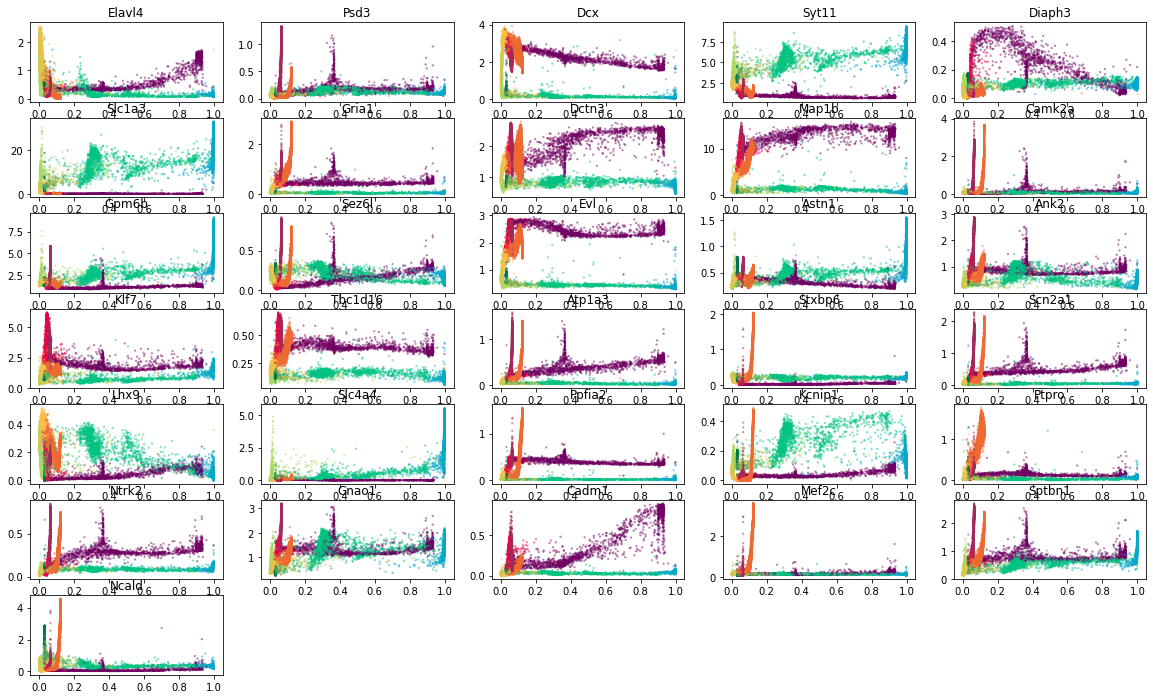

In [161]:
gene_list=['Elavl4','Psd3', 'Dcx', 'Syt11', 'Diaph3', 'Slc1a3', 'Gria1', 'Dctn3', 'Map1b', 'Camk2a', 'Gpm6b', 'Sez6l', 'Evl', 'Astn1', 'Ank2', 'Klf7', 'Tbc1d16', 'Atp1a3', 'Stxbp6', 'Scn2a1', 'Lhx9', 'Slc4a4', 'Ppfia2', 'Kcnip1', 'Ptpro', 'Ntrk2', 'Gnao1', 'Cadm1', 'Mef2c', 'Sptbn1', 'Ncald']


ncols=5
fig = plt.figure(figsize=(20,12))
for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    # ax.axis('off')

## Gene Parameter in Cell Level

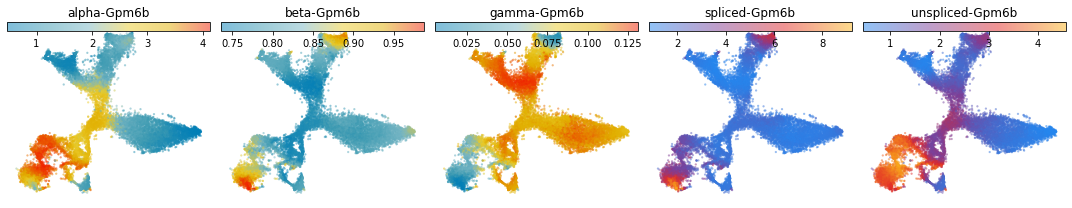

In [162]:
gene_samples=['Gpm6b']
for gene in gene_samples:
    fig, ax = plt.subplots(ncols=5, figsize=(15,3))
    cdplt.cell.scatter_cell(ax[0],cellDancer_df, colors='alpha', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[1],cellDancer_df, colors='beta', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[2],cellDancer_df, colors='gamma', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[3],cellDancer_df, colors='splice', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[4],cellDancer_df, colors='unsplice', 
                 gene=gene, velocity=False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    ax[0].set_title('alpha-'+gene)
    ax[1].set_title('beta-'+gene)
    ax[2].set_title('gamma-'+gene)
    ax[3].set_title('spliced-'+gene)
    ax[4].set_title('unspliced-'+gene)
    plt.tight_layout()
    plt.show()

## UMAP using alpha, beta, and gamma

In [31]:
cellDancer_df=embedding(cellDancer_df,'alpha')
cellDancer_df=embedding(cellDancer_df,'beta')
cellDancer_df=embedding(cellDancer_df,'gamma')
cellDancer_df=embedding(cellDancer_df,'alpha_beta_gamma')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


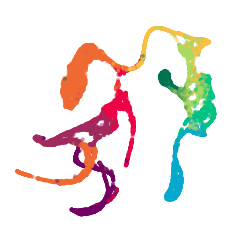

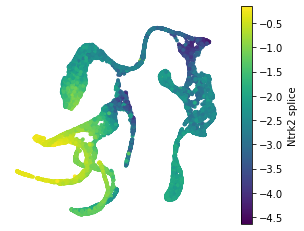

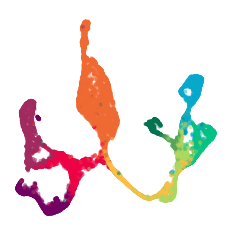

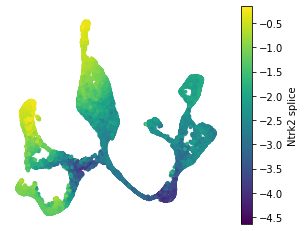

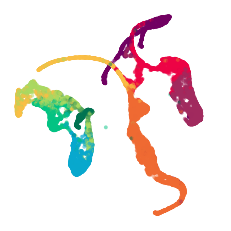

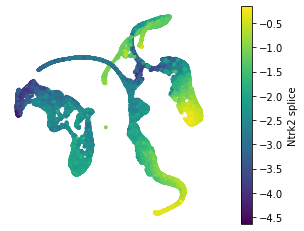

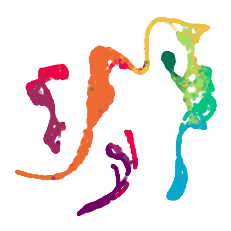

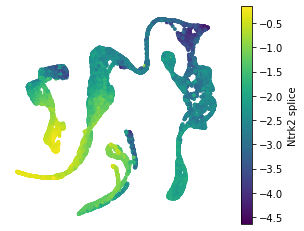

In [35]:
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,color_map=cdplt.colormap.colormap_neuro, save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)